In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from matplotlib import rc
from numpy import inf

from AtlasCommonUtils import SetAtlasStyle
from ROOT import TLatex



rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)




#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

Welcome to JupyROOT 6.22/02


In [2]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [3]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [4]:
def getJetData(inputFiles, isMC=False):
    
    cols = []
    scalar = []
    scalar.append('isBKG')
    scalar.append('polarization')
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    
    scalar.append('x_e')
    scalar.append('y_e')
    scalar.append('Q2_e')
    
    scalar.append('vertex_z')
    scalar.append('ptratio')
    scalar.append('ptmiss')
    scalar.append('acoplanarity')
    scalar.append('Empz')
    scalar.append('njets')

    scalar.append('e_eta')
    scalar.append('e_rap')
    scalar.append('e_theta')
    scalar.append('e_p')
    scalar.append('e_pt')
    scalar.append('e_phi')
    scalar.append('gene_pt')
    
    cols.append('jet_p')
    cols.append('jet_pt')
    cols.append('jet_qt')
    cols.append('jet_dphi')
    cols.append('jet_z')
    cols.append('jet_eta')
    cols.append('jet_phi')
    
    if(isMC):
        scalar.append('Weight')
        scalar.append('WeightGen')
        scalar.append('geny')
        scalar.append('gene_rap')

        cols.append('genjet_p')
        cols.append('genjet_pt')
        cols.append('genjet_eta')

        cols.append('genjet_qt')
        cols.append('genjet_dphi')
        cols.append('genjet_z')
        

    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists+cols,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print ('\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds')
    return pd.concat([x for x in dataframes])

In [5]:
def applyCutsJets(df,isMC=False):
    temp = df
    temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    temp = applyCut(temp, '0.2 < y < 0.7', '0.2 < y < 0.7')
    temp = applyCut(temp, 'Q2>150', 'Q2>150')
    #temp = applyCut(temp, 'e_pt>15', 'e_pt >15')
    #temp = applyCut(temp, 'jet_pt>10', 'jet_pt>10')
    temp = applyCut(temp, 'isBKG<1.0', 'isBKG')

    #temp = applyCut(temp, 'jet_qt<5', 'jet_qt<5')

    #temp = applyCut(temp, 'dphi_e_jet > 2.74', 'dphi_e_jet>3.14159-0.4')
    #temp = applyCut(temp, 'Q2>100.0', ' Q2>100.0')
    
    #temp.eval('dphi = 3.14159-jet_dphi', inplace=True)
    temp.eval('jet_qtnormjetpt= jet_qt/jet_pt', inplace=True)
    temp.eval('jet_qtnormept= jet_qt/e_pt', inplace=True)
    if(isMC):
        temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
        temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes

In [6]:
data_cut     = applyCutsJets(getJetData(['data_echeme.root']))
mc_cut = applyCutsJets(getJetData(['rapgap.root'],isMC=True),isMC=True)
altmc_cut= applyCutsJets(getJetData(['djangoh.root'],isMC=True),isMC=True)


 Processed data_echeme.root in 3.5 seconds
abs(vertex_z)<25 and and vertex_z!=0 111629  fraction kept: 90.0
0.2 < y < 0.7 66449  fraction kept: 59.5
Q2>150 66449  fraction kept: 100.0
isBKG 57257  fraction kept: 86.2

 Processed rapgap.root in 40.8 seconds
abs(vertex_z)<25 and and vertex_z!=0 958520  fraction kept: 96.7
0.2 < y < 0.7 677816  fraction kept: 70.7
Q2>150 677816  fraction kept: 100.0
isBKG 600050  fraction kept: 88.5

 Processed djangoh.root in 36.8 seconds
abs(vertex_z)<25 and and vertex_z!=0 920853  fraction kept: 96.6
0.2 < y < 0.7 650115  fraction kept: 70.6
Q2>150 650115  fraction kept: 100.0
isBKG 576934  fraction kept: 88.7


### Define UniFold Algorithm


In [7]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

2020-11-17 11:48:10.025016: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/miguel/anaconda3/envs/my_root_env/lib:
2020-11-17 11:48:10.025037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Define features (input for the unfolding)

In [15]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
dphi_unknown_G = altmc_cut['genjet_dphi']
dphi_unknown_S = altmc_cut['jet_dphi']

ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
ept_unknown_G = altmc_cut['gene_pt']
ept_unknown_S = altmc_cut['e_pt']

jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']
jetpt_unknown_G = altmc_cut['genjet_pt']
jetpt_unknown_S = altmc_cut['jet_pt']

jeteta_0_G = mc_cut['genjet_eta']
jeteta_0_S =mc_cut['jet_eta']
jeteta_unknown_G = altmc_cut['genjet_eta']
jeteta_unknown_S = altmc_cut['jet_eta']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']
qt_unknown_G = altmc_cut['genjet_qtnormjetpt']
qt_unknown_S = altmc_cut['jet_qtnormjetpt']

erap_0_G = mc_cut['gene_rap']
erap_0_S = mc_cut['e_rap']
erap_unknown_G = altmc_cut['gene_rap']
erap_unknown_S = altmc_cut['e_rap']

z_0_G = mc_cut['genjet_z']
z_0_S = mc_cut['jet_z']
z_unknown_G = altmc_cut['genjet_z']
z_unknown_S = altmc_cut['jet_z']


## Show input for closure test (i.e. synthetic and natural datasets using mc and altmc)

In [ ]:
fig, ax = plt.subplots(2,
                       2,
                       figsize=(12, 10),
                       constrained_layout=True,
                       sharey='row')

bins = np.linspace(2.5, np.pi, 20)
## Define Multifold 
#bins = np.linspace(5, 50, 45)

ax[0, 0].set_title('Synthetic',fontsize=22)
ax[0, 0].set_xlabel(r'd#phi')
ax[0, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[0, 0].hist(dphi_0_G, bins=bins, alpha=0.5, label='Generation')
hS0, _, _ = ax[0, 0].hist(dphi_0_S, bins=bins, alpha=0.5, label='Simulation')
legend = ax[0, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[0, 1].set_title('"Natural"',fontsize=22)
ax[0, 1].set_xlabel(namevariable)
hG1, _, _ = ax[0, 1].hist(dphi_unknown_G, bins=bins, alpha=0.5, label='Truth')
hS1, _, _ = ax[0, 1].hist(dphi_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[0, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')






bins = np.linspace(7, 50, 43)

ax[1, 0].set_xlabel('Electron pT [GeV]')
ax[1, 0].set_ylabel('Events per bin')
hG0, _, _ = ax[1, 0].hist(ept_0_G,
                          bins=bins,
                          alpha=0.5,
                          label='Generation')
hS0, _, _ = ax[1, 0].hist(ept_0_S,
                          bins=bins,
                          alpha=0.5,
                          label='Simulation')
legend = ax[1, 0].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1, 1].set_xlabel('Electron pT [GeV]')
hG1, _, _ = ax[1, 1].hist(ept_unknown_G,
                          bins=bins,
                          alpha=0.5,
                          label='Truth')
hS1, _, _ = ax[1, 1].hist(ept_unknown_S,
                          bins=bins,
                          alpha=0.5,
                          label='Detector')
legend = ax[1, 1].legend(loc='best', frameon=False)
plt.setp(legend.get_title(), multialignment='center',fontsize=32)

# plt.ylim([0,1.5*np.max(np.concatenate((hG0, hG1, hS0, hS1)))])

fig.show()

## Define Multifold 

In [16]:
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))
"""    Arguments:
        num_observables: number of observables to 
                            simultaneously unfold (integer)
                            
        iterations: number of iterations (integer)
        
        theta0_G: tuple or list of nominal 
                    generation-level observables as Numpy arrays
                    
        theta0_S: tuple or list of nominal 
                    simulation-level observables as Numpy arrays
                    
        theta_unknown_S: tuple or list of "natural" 
                            (unknown) simulation-level observables 
                            to be unfolded as Numpy arrays
        
        Returns:
        - A Numpy array of weights to reweight distributions in 
        theta0_G to the unfolded distribution of theta_unknown_S
        
        - The model used to calculate those weights
"""


def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S):

    theta0_G = np.stack(theta0_G, axis=1)
    theta0_S = np.stack(theta0_S, axis=1)
    theta_unknown_S = np.stack(theta_unknown_S, axis=1)

    labels0 = np.zeros(len(theta0_G))
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    # shape = (iteration, step, event)

    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_G))

    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

    model = Model(inputs=inputs, outputs=outputs)

    earlystopping = EarlyStopping(patience=10,
                                  verbose=1,
                                  restore_best_weights=True)

    # from NN (DCTR)
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights)) # np.squeeze(weights)

    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate(
            (weights_push, np.ones(len(theta_unknown_S))))
        # actual weights for Sim., ones for Data

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[i, :1, :] = weights_pull
        
        print('Max and min weight_pull in Step #1')
        print(max(weights[i, 1, :]))
        print(min(weights[i, 1, :]))
        

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen., actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=10000,
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[i, 1:2, :] = weights_pull
        
        print('Max and min weight_pull in Step #2')
        print(max(weights[i, 1:2, :]))
        print(min(weights[i, 1:2, :]))

    return weights, model

## Unfold two variables simultaneously

In [ ]:
K.clear_session()

In [ ]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(dphi_0_G / 100., ept_0_G / 100.),
                       theta0_S=(dphi_0_S / 100., ept_0_S / 100.),
                       theta_unknown_S=(dphi_unknown_S / 100.,
                                        ept_unknown_S / 100.))

In [ ]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 30)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(1,
                           num_observables,
                           figsize=(12, 6),
                           constrained_layout=True)
    ax[0].set_xlabel(namevariable)
    ax[0].set_ylabel('Events per bin (Normalized)')
    ax[0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0].legend(frameon=False)

    bins = np.linspace(7, 50, 43)

    ax[1].set_xlabel('Electron pT [GeV]')
    ax[1].set_ylabel('Events per bin (Normalized)')
    ax[1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[1].legend(frameon=False)

    fig.show()
    plt.show()

## 6D

In [17]:
K.clear_session()

In [18]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=2,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
89/89 [==============================] - 25s 286ms/step - loss: 0.6907 - accuracy: 0.5332 - val_loss: 0.6885 - val_accuracy: 0.5434
Epoch 2/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5425 - val_loss: 0.6883 - val_accuracy: 0.5438
Epoch 3/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5431 - val_loss: 0.6882 - val_accuracy: 0.5440
Epoch 4/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5436 - val_loss: 0.6880 - val_accuracy: 0.5441
Epoch 5/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5433 - val_loss: 0.6880 - val_accuracy: 0.5441
Epoch 6/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5438 - val_loss: 0.6882 - val_accuracy: 0.5443
Epoch 7/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.5440 - val_loss: 0.6879 - val_accu

89/89 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5475 - val_loss: 0.6872 - val_accuracy: 0.5470
Epoch 59/200
89/89 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5475 - val_loss: 0.6873 - val_accuracy: 0.5479
Epoch 60/200
89/89 [==============================] - 0s 5ms/step - loss: 0.6871 - accuracy: 0.5477 - val_loss: 0.6871 - val_accuracy: 0.5474
Epoch 61/200
89/89 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5477 - val_loss: 0.6873 - val_accuracy: 0.5476
Epoch 62/200
89/89 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5475 - val_loss: 0.6872 - val_accuracy: 0.5473
Epoch 63/200
89/89 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5475 - val_loss: 0.6874 - val_accuracy: 0.5462
Epoch 64/200
89/89 [==============================] - 0s 5ms/step - loss: 0.6870 - accuracy: 0.5477 - val_loss: 0.6872 - val_accuracy: 0.5468
Epoch 65/200
89/89 

91/91 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.4999 - val_loss: 0.6776 - val_accuracy: 0.4997
Epoch 8/200
91/91 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.5005 - val_loss: 0.6776 - val_accuracy: 0.4994
Epoch 9/200
91/91 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.5000 - val_loss: 0.6776 - val_accuracy: 0.4991
Epoch 10/200
91/91 [==============================] - 1s 5ms/step - loss: 0.6775 - accuracy: 0.5000 - val_loss: 0.6776 - val_accuracy: 0.4998
Epoch 11/200
91/91 [==============================] - 0s 5ms/step - loss: 0.6776 - accuracy: 0.4999 - val_loss: 0.6776 - val_accuracy: 0.4990
Epoch 12/200
91/91 [==============================] - 0s 5ms/step - loss: 0.6775 - accuracy: 0.5002 - val_loss: 0.6776 - val_accuracy: 0.4993
Epoch 00012: early stopping
Max and min weight_pull in Step #2
[0.80840331 1.23923481 1.19857967 ... 0.94611359 1.16588497 0.72710663]
[0.80840331 1.23923481 1.198

In [ ]:
for i in range(len(weights)):
    print(max(weights[i, 1, :]))
    print(min(weights[i, 1, :]))

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


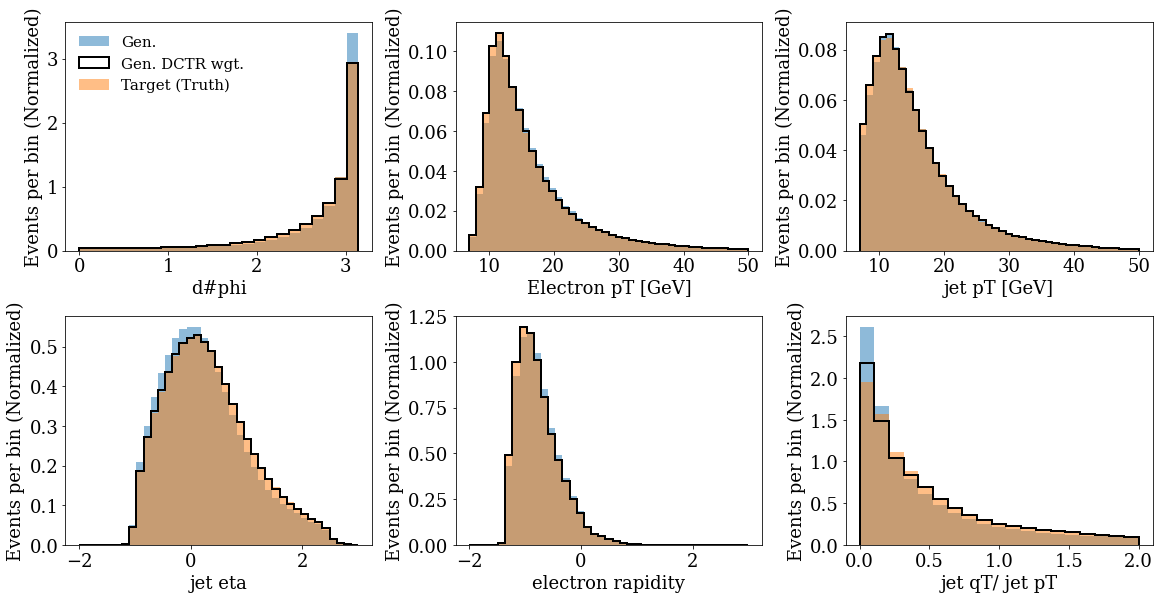

ITERATION: 2


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:121: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


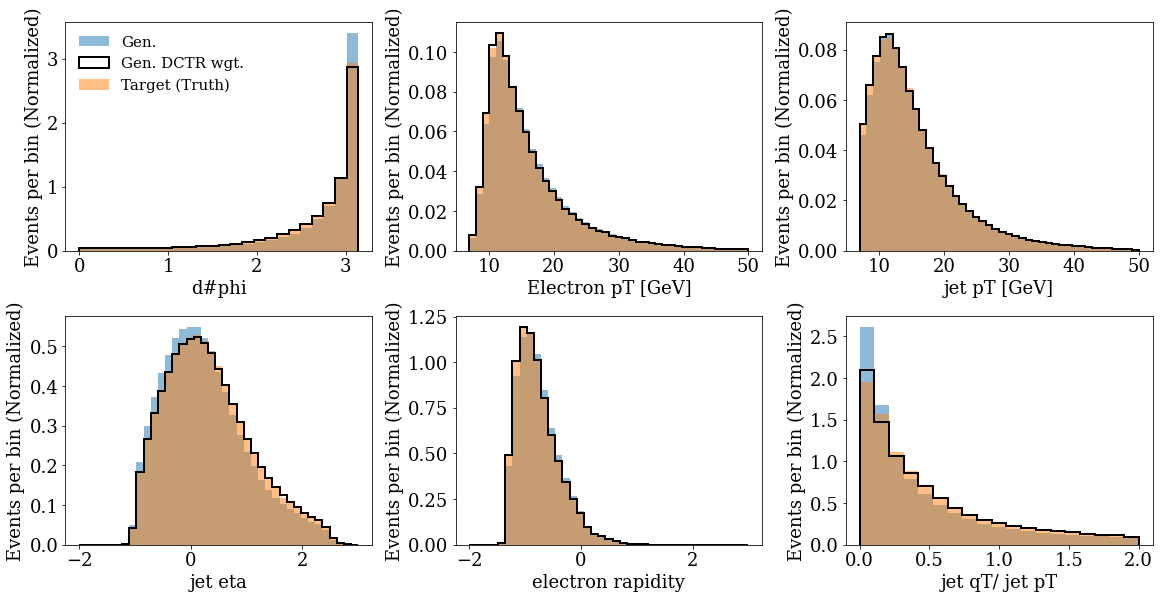

In [19]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 25)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(2,
                           3,
                           figsize=(16, 8),
                           constrained_layout=True)
    ax[0,0].set_xlabel(r'd#phi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(7, 50, 43)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(7, 50, 43)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 20)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_G,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    


    
    
    
    fig.show()
    plt.show()

In [20]:
K.clear_session()

## Define features with data

In [49]:
dphi_0_G = mc_cut['genjet_dphi']
dphi_0_S =mc_cut['jet_dphi']
dphi_unknown_S = data_cut['jet_dphi']

ept_0_G = mc_cut['gene_pt']
ept_0_S =mc_cut['e_pt']
ept_unknown_S = data_cut['e_pt']

jetpt_0_G = mc_cut['genjet_pt']
jetpt_0_S =mc_cut['jet_pt']
jetpt_unknown_S = data_cut['jet_pt']

jeteta_0_G = mc_cut['genjet_eta']
jeteta_0_S =mc_cut['jet_eta']
jeteta_unknown_S = data_cut['jet_eta']

qt_0_G = mc_cut['genjet_qtnormjetpt']
qt_0_S = mc_cut['jet_qtnormjetpt']
qt_unknown_S = data_cut['jet_qtnormjetpt']

erap_0_G = mc_cut['gene_rap']
erap_0_S = mc_cut['e_rap']
erap_unknown_S = data_cut['e_rap']


z_0_G = mc_cut['genjet_z']
z_0_S = mc_cut['jet_z']
z_unknown_S = data_cut['jet_z']

## Run unfolding on data

In [54]:
K.clear_session()

In [51]:
num_observables = 2

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=1,
                       theta0_G=(ept_0_G/10.0, jetpt_0_G/10.0),
                       theta0_S=(ept_0_S/10.0, jetpt_0_S/10.0),
                       theta_unknown_S=(ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
50/50 [==============================] - 17s 337ms/step - loss: 0.4205 - accuracy: 0.8782 - val_loss: 0.3184 - val_accuracy: 0.9121
Epoch 2/200
50/50 [==============================] - 0s 6ms/step - loss: 0.3090 - accuracy: 0.9132 - val_loss: 0.3079 - val_accuracy: 0.9121
Epoch 3/200
50/50 [==============================] - 0s 7ms/step - loss: 0.3023 - accuracy: 0.9132 - val_loss: 0.3016 - val_accuracy: 0.9121
Epoch 4/200
50/50 [==============================] - 0s 8ms/step - loss: 0.2972 - accuracy: 0.9132 - val_loss: 0.2982 - val_accuracy: 0.9121
Epoch 5/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2952 - accuracy: 0.9132 - val_loss: 0.2975 - val_accuracy: 0.9121
Epoch 6/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2948 - accuracy: 0.9132 - val_loss: 0.2972 - val_accuracy: 0.9121
Epoch 7/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2947 - accuracy: 0.9132 - val_loss: 0.2973 - val_accu

50/50 [==============================] - 0s 5ms/step - loss: 0.2924 - accuracy: 0.9138 - val_loss: 0.2948 - val_accuracy: 0.9128
Epoch 59/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2924 - accuracy: 0.9138 - val_loss: 0.2948 - val_accuracy: 0.9128
Epoch 60/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2924 - accuracy: 0.9138 - val_loss: 0.2948 - val_accuracy: 0.9128
Epoch 61/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2924 - accuracy: 0.9138 - val_loss: 0.2948 - val_accuracy: 0.9128
Epoch 62/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2923 - accuracy: 0.9138 - val_loss: 0.2950 - val_accuracy: 0.9127
Epoch 63/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2923 - accuracy: 0.9138 - val_loss: 0.2948 - val_accuracy: 0.9128
Epoch 64/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2924 - accuracy: 0.9138 - val_loss: 0.2948 - val_accuracy: 0.9128
Epoch 65/200
50/50 

Epoch 116/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2921 - accuracy: 0.9139 - val_loss: 0.2947 - val_accuracy: 0.9128
Epoch 117/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2921 - accuracy: 0.9139 - val_loss: 0.2947 - val_accuracy: 0.9129
Epoch 118/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2921 - accuracy: 0.9139 - val_loss: 0.2947 - val_accuracy: 0.9128
Epoch 00118: early stopping
Max and min weight_pull in Step #1
1.0
1.0

STEP 2

Epoch 1/200
91/91 [==============================] - 26s 283ms/step - loss: 0.1623 - accuracy: 0.5001 - val_loss: 0.1622 - val_accuracy: 0.4996
Epoch 2/200
91/91 [==============================] - 0s 5ms/step - loss: 0.1622 - accuracy: 0.5001 - val_loss: 0.1622 - val_accuracy: 0.4996
Epoch 3/200
91/91 [==============================] - 0s 5ms/step - loss: 0.1621 - accuracy: 0.5001 - val_loss: 0.1623 - val_accuracy: 0.4996
Epoch 4/200
91/91 [==============================] - 0s 5ms/step 

In [ ]:
num_observables = 6

# simple / 100. standardization s.t. data is of order ~1

weights, _ = multifold(num_observables=num_observables,
                       iterations=3,
                       theta0_G=(dphi_0_G, ept_0_G/10.0, jetpt_0_G/10.0,jeteta_0_G,qt_0_G,erap_0_G),
                       theta0_S=(dphi_0_S, ept_0_S/10.0, jetpt_0_S/10.0,jeteta_0_S, qt_0_S,erap_0_S),
                       theta_unknown_S=(dphi_unknown_S,
                                        ept_unknown_S/10.0,
                                        jetpt_unknown_S/10.0,
                                        jeteta_unknown_S,
                                        qt_unknown_S,
                                        erap_unknown_S
                                        )
                      )


ITERATION: 1

STEP 1

Epoch 1/200
50/50 [==============================] - 15s 306ms/step - loss: 0.4150 - accuracy: 0.8212 - val_loss: 0.3017 - val_accuracy: 0.9126
Epoch 2/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2986 - accuracy: 0.9130 - val_loss: 0.2981 - val_accuracy: 0.9126
Epoch 3/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2961 - accuracy: 0.9130 - val_loss: 0.2961 - val_accuracy: 0.9126
Epoch 4/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2944 - accuracy: 0.9130 - val_loss: 0.2946 - val_accuracy: 0.9126
Epoch 5/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2932 - accuracy: 0.9130 - val_loss: 0.2938 - val_accuracy: 0.9126
Epoch 6/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2926 - accuracy: 0.9130 - val_loss: 0.2933 - val_accuracy: 0.9126
Epoch 7/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2921 - accuracy: 0.9130 - val_loss: 0.2929 - val_accu

50/50 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.9137 - val_loss: 0.2899 - val_accuracy: 0.9132
Epoch 59/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.9136 - val_loss: 0.2899 - val_accuracy: 0.9132
Epoch 60/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9137 - val_loss: 0.2900 - val_accuracy: 0.9132
Epoch 61/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2888 - accuracy: 0.9137 - val_loss: 0.2901 - val_accuracy: 0.9132
Epoch 62/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9137 - val_loss: 0.2901 - val_accuracy: 0.9132
Epoch 63/200
50/50 [==============================] - 0s 6ms/step - loss: 0.2889 - accuracy: 0.9137 - val_loss: 0.2900 - val_accuracy: 0.9132
Epoch 64/200
50/50 [==============================] - 0s 5ms/step - loss: 0.2888 - accuracy: 0.9137 - val_loss: 0.2901 - val_accuracy: 0.9132
Epoch 65/200
50/50 

50/50 [==============================] - 0s 5ms/step - loss: 0.1204 - accuracy: 0.6151 - val_loss: 0.1203 - val_accuracy: 0.5273
Epoch 7/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1203 - accuracy: 0.5656 - val_loss: 0.1203 - val_accuracy: 0.6693
Epoch 8/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1203 - accuracy: 0.5696 - val_loss: 0.1203 - val_accuracy: 0.5898
Epoch 9/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1203 - accuracy: 0.5583 - val_loss: 0.1202 - val_accuracy: 0.5967
Epoch 10/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1203 - accuracy: 0.5734 - val_loss: 0.1203 - val_accuracy: 0.6713
Epoch 11/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1203 - accuracy: 0.5461 - val_loss: 0.1202 - val_accuracy: 0.5279
Epoch 12/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1202 - accuracy: 0.5566 - val_loss: 0.1202 - val_accuracy: 0.5034
Epoch 13/200
50/50 [==

Epoch 64/200
50/50 [==============================] - 1s 15ms/step - loss: 0.1200 - accuracy: 0.5303 - val_loss: 0.1200 - val_accuracy: 0.5819
Epoch 65/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1199 - accuracy: 0.5459 - val_loss: 0.1200 - val_accuracy: 0.4847
Epoch 66/200
50/50 [==============================] - 0s 6ms/step - loss: 0.1199 - accuracy: 0.5254 - val_loss: 0.1200 - val_accuracy: 0.5658
Epoch 67/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1199 - accuracy: 0.5239 - val_loss: 0.1200 - val_accuracy: 0.6044
Epoch 68/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1199 - accuracy: 0.5291 - val_loss: 0.1200 - val_accuracy: 0.6046
Epoch 69/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1199 - accuracy: 0.5324 - val_loss: 0.1200 - val_accuracy: 0.6183
Epoch 70/200
50/50 [==============================] - 0s 5ms/step - loss: 0.1199 - accuracy: 0.5211 - val_loss: 0.1200 - val_accuracy: 0.6843
Epoch

In [48]:
for i in range(len(weights)):
    print (weights.shape)
    print((weights[i, 1, :]).shape)
    print((weights[i, 1, :]).shape)
    print((weights[i, 1:2, :][0]).shape)


(1, 2, 600050)
(600050,)
(600050,)
(600050,)


## Plot unfolded data

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:131: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


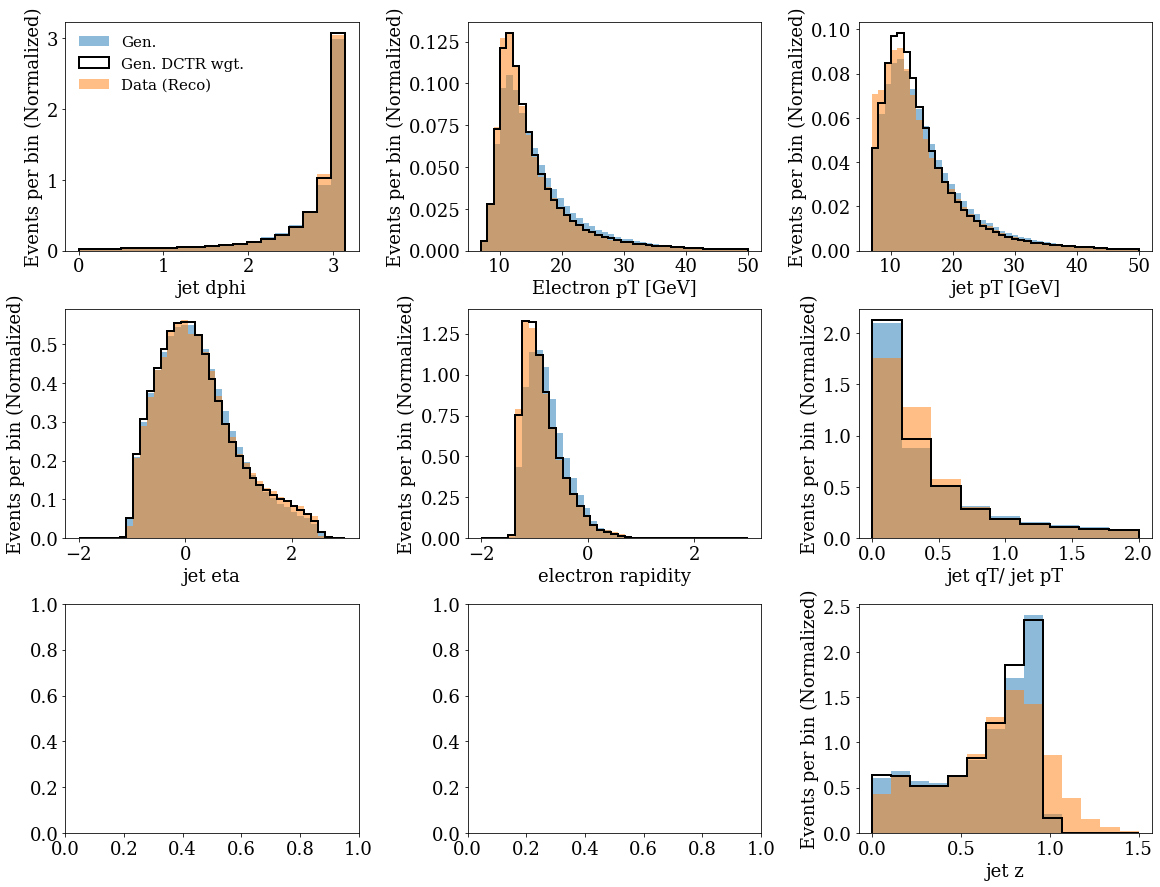

In [60]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 20)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(3,
                           3,
                           figsize=(16, 12),
                           constrained_layout=True)
    ax[0,0].set_xlabel('jet dphi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,0].hist(dphi_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_S,
               bins=bins,
               label=r'Data (Reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    bins = np.linspace(7, 50, 43)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,1].hist(ept_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(7, 50, 43)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[0,2].hist(jetpt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,0].hist(jeteta_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_S,
               bins=bins,
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,1].hist(erap_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_S,
               bins=bins,
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 10)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[1,2].hist(qt_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_S,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(0, 1.5, 15)

    
    ax[2,2].set_xlabel('jet z')
    ax[2,2].set_ylabel('Events per bin (Normalized)')
    ax[2,2].hist(z_0_G, bins=bins, label=r'Gen.', **plot_style_2)
    ax[2,2].hist(z_0_G,
               bins=bins,
               weights=weights[i, 1, :],
               label=r'Gen. DCTR wgt.',
               **plot_style_1)
    ax[2,2].hist(z_unknown_S,
               bins=bins,
               **plot_style_2)
    

    
    
    
    fig.show()
    plt.show()

## Plot the data at reco level and the gen weighted to match the data at reco level

ITERATION: 1


/home/miguel/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:137: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


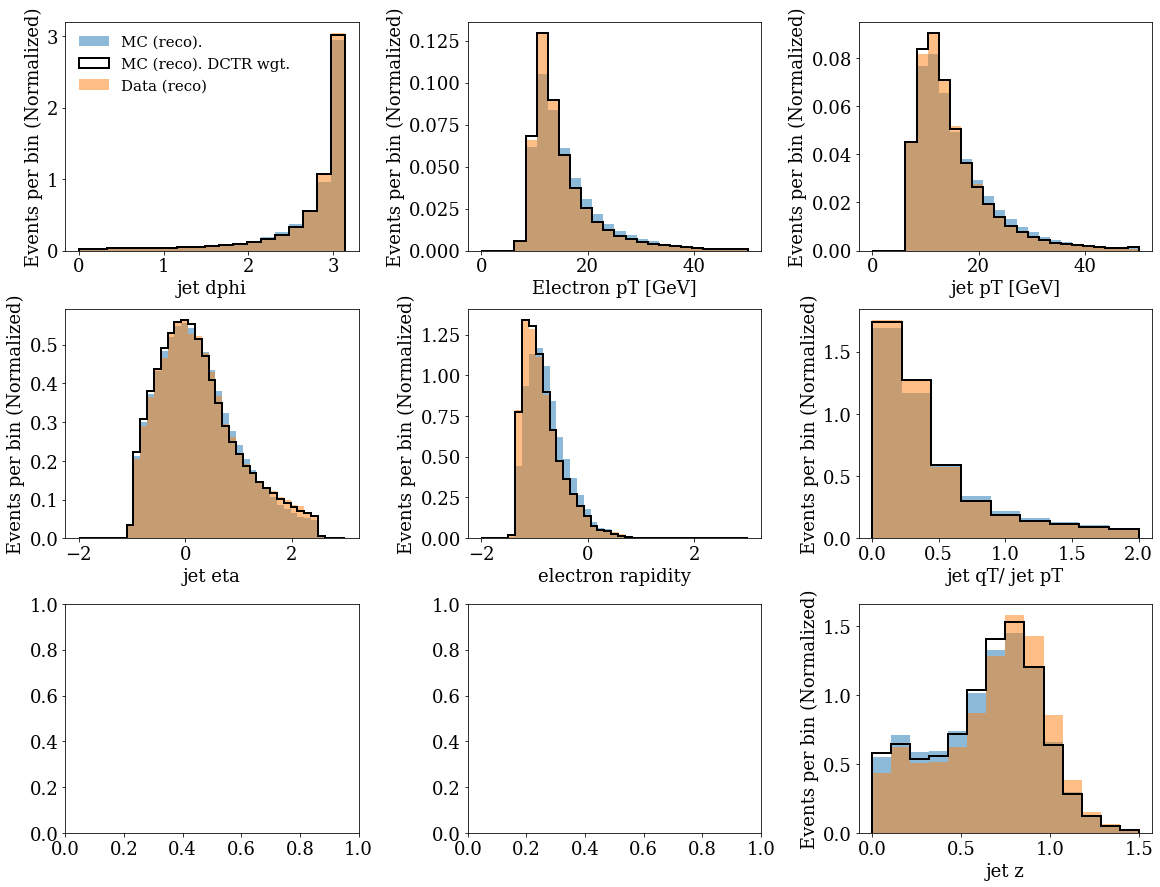

In [59]:
for i in range(len(weights)):

    print("ITERATION: {}".format(i + 1))
    bins = np.linspace(0.0, np.pi, 20)
    #bins = np.linspace(5, 50, 45)

    fig, ax = plt.subplots(3,
                           3,
                           figsize=(16, 12),
                           constrained_layout=True)
    ax[0,0].set_xlabel('jet dphi')
    ax[0,0].set_ylabel('Events per bin (Normalized)')
    ax[0,0].hist(dphi_0_S, bins=bins, label=r'MC (reco).', **plot_style_2)
    ax[0,0].hist(dphi_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC (reco). DCTR wgt.',
               **plot_style_1)

    ax[0,0].hist(dphi_unknown_S,
               bins=bins,
               label=r'Data (reco)',
               **plot_style_2)
    ax[0,0].legend(frameon=False)

    
    
    
    
    
    
    bins = np.linspace(0, 50, 25)
    #bins = np.linspace(0, 2.0, 40)

    ax[0,1].set_xlabel('Electron pT [GeV]')
    ax[0,1].set_ylabel('Events per bin (Normalized)')
    ax[0,1].hist(ept_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[0,1].hist(ept_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt. = Unfolded',
               **plot_style_1)
    ax[0,1].hist(ept_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[1].legend(frameon=False)

    
    
    bins = np.linspace(0, 50, 25)
   # bins = np.linspace(0, 2.0, 40)

    ax[0,2].set_xlabel('jet pT [GeV]')
    ax[0,2].set_ylabel('Events per bin (Normalized)')
    ax[0,2].hist(jetpt_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[0,2].hist(jetpt_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[0,2].hist(jetpt_unknown_S,
               bins=bins,
               **plot_style_2)
    #ax[2].legend(frameon=False)
    
    bins = np.linspace(-2.0, 3.0, 40)

    
    ax[1,0].set_xlabel('jet eta')
    ax[1,0].set_ylabel('Events per bin (Normalized)')
    ax[1,0].hist(jeteta_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,0].hist(jeteta_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,0].hist(jeteta_unknown_S,
               bins=bins,
               **plot_style_2)
    
    bins = np.linspace(-2.0, 3.0, 40)

    ax[1,1].set_xlabel('electron rapidity')
    ax[1,1].set_ylabel('Events per bin (Normalized)')
    ax[1,1].hist(erap_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,1].hist(erap_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,1].hist(erap_unknown_S,
               bins=bins,
               **plot_style_2)
    
    
    
    
    
    
    
    
    bins = np.linspace(0, 2.0, 10)

    
    ax[1,2].set_xlabel('jet qT/ jet pT')
    ax[1,2].set_ylabel('Events per bin (Normalized)')
    ax[1,2].hist(qt_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[1,2].hist(qt_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[1,2].hist(qt_unknown_S,
               bins=bins,
               label=r'Target (Truth)',
               **plot_style_2)
    
    bins = np.linspace(0, 1.5, 15)

    
    ax[2,2].set_xlabel('jet z')
    ax[2,2].set_ylabel('Events per bin (Normalized)')
    ax[2,2].hist(z_0_S, bins=bins, label=r'MC (reco)', **plot_style_2)
    ax[2,2].hist(z_0_S,
               bins=bins,
               weights=weights[i, 1:2, :][0],
               label=r'MC DCTR wgt.',
               **plot_style_1)
    ax[2,2].hist(z_unknown_S,
               bins=bins,
               **plot_style_2)
    

    
    
    
    fig.show()
    plt.show()